## 1D Linear operator with two parameters

In the previous examples we focus on systems with only one parameter. To see if the framework can be applied to a more general case, we use a 1D linear operator on two parameters, and verify the prediction. 

Here we set up the linear operator as follows:

\begin{align*}
\mathcal{L}_x^\phi u(x) &= f(x) \\
\mathcal{L}_x^\phi &:= \phi_1 \cdot + \phi_2\frac{d}{dx}\cdot
\end{align*}


A suitable solution can be: 
\begin{align*}
\left.\begin{aligned} u ( x ) & = \sin ( x ) \\ f ( x ) & = \phi _ { 1 } \sin ( x ) + \phi _ { 2 } \cos ( x ) \\ x & \in [ 0,1 ] \end{aligned} \right.
\end{align*}


In this example, we assume $\phi_1 = 2$, $\phi_2 = 5$, and estimate $\phi_1$ and $\phi_2$.


#### Simulate data


In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
##Initiating f(x) and u(x) with 20 data points
x = np.random.rand(20)
phi1 = 2.0
phi2 = 5.0
y_u = np.sin(x)
y_f = phi1*np.sin(x) + phi2*np.cos(x)

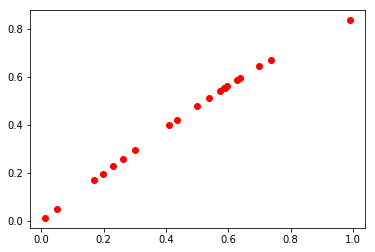

In [3]:

plt.plot(x, y_u, 'ro')
plt.show()

#### Evaluate kernels
Corresponding kernels are defined as following:

$k _ { u u } \left( x _ { i } , x _ { j } ; \theta \right) = \theta \exp \left( - \frac { 1 } { 2 l } \left( x _ { i } - x _ { j } \right) ^ { 2 } \right)$

$\left. \begin{array} { l } { k _ { f f } \left( x _ { i } , x _ { j } ; \theta , \phi _ { 1 } , \phi _ { 2 } \right) } \\ { = \mathcal { L } _ { x _ { i } } ^ { \phi } \mathcal { L } _ { x _ { j } } ^ { \phi } k _ { u u } \left( x _ { i } , x _ { j } ; \theta \right) } \\ { = \mathcal { L } _ { x _ { i } } ^ { \phi } \left( \phi _ { 1 } k _ { u u } + \phi _ { 2 } \frac { \partial } { \partial x _ { j } } k _ { u u } \right) } \\ { = \phi _ { 1 } ^ { 2 } k _ { u u } + \phi _ { 1 } \phi _ { 2 } \frac { \partial } { \partial x _ { j } } k _ { u u } + \phi _ { 1 } \phi _ { 2 } \frac { \partial } { \partial x _ { i } } k _ { u u } + \phi _ { 2 } ^ { 2 } \frac { \partial } { \partial x _ { i } } \frac { \partial } { \partial x _ { i } } k _ { u u } } \end{array} \right.$

$k_{fu}(x_i,x_j;\theta,\phi_1, \phi_2) \\
= \mathcal{L}_{x_i}^\phi k_{uu}(x_i, x_j; \theta) \\
= \phi_1 k_{uu} + \phi_2 \frac{\partial}{\partial x_i}k_{uu}$

$\left. \begin{array} { l } { k _ { u f } \left( x _ { i } , x _ { j } ; \theta , \phi _ { 1 } , \phi _ { 2 } \right) } \\ { = \mathcal { L } _ { x _ { j } } ^ { \phi } k _ { u u } \left( x _ { i } , x _ { j } ; \theta \right) } \end{array} \right.$ 

In [4]:
x_i, x_j, theta, phi1, phi2 = sp.symbols('x_i x_j theta phi1 phi2')
kuu_sym = sp.exp(theta*(-1)/(2)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta), kuu_sym, "numpy")
def kuu(x, theta):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta)
    return k

In [5]:
kff_sym = phi1**2*kuu_sym + phi1*phi2*sp.diff(kuu_sym, x_j) + phi1*phi2*sp.diff(kuu_sym, x_i) + phi2**2*sp.diff(kuu_sym, x_j, x_i)
kff_fn = sp.lambdify((x_i, x_j, theta, phi1,phi2), kff_sym, "numpy")
def kff(x, theta, phi1, phi2):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, phi1, phi2)
    return k

In [6]:
kfu_sym = phi1*kuu_sym + phi2*sp.diff(kuu_sym, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, phi1, phi2), kfu_sym, "numpy")
def kfu(x1, x2, theta, phi1, phi2):
    k = np.zeros((x1.size, x2.size))
    for i in range(x1.size):
        for j in range(x2.size):
            k[i,j] = kfu_fn(x1[i], x2[j], theta, phi1, phi2)
    return k

In [7]:
def kuf(x1, x2, theta, phi1, phi2):
    return kfu(x1,x2,theta,phi1, phi2).T

#### step 3: define negative log marginal likelihood  



$K = \begin{bmatrix}
k_{uu}(X_u, X_u; \theta) + \sigma_u^2I & k_{uf}(X_u, X_f; \theta, \phi) \\
k_{fu}(X_f, X_u; \theta, \phi) & k_{ff}(X_f, X_f; \theta, \phi) + \sigma_f^2I
\end{bmatrix}$

For simplicity, assume $\sigma_u = \sigma_f$.

$\mathcal{NLML} = \frac{1}{2} \left[ log|K| + y^TK^{-1}y + Nlog(2\pi) \right]$

where $y = \begin{bmatrix}
y_u \\
y_f
\end{bmatrix}$

In [8]:
def nlml(params, x1, x2, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [kuu(x1, params[0]) + s*np.identity(x1.size), kuf(x1, x2, params[0], params[1], params[2])],
        [kfu(x1, x2, params[0], params[1], params[2]), kff(x2, params[0], params[1], params[2]) + s*np.identity(x2.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [9]:
nlml((1,2,5), x, x, y_u, y_f, 1e-7)


4451304.977390464

#### Optimize hyperparameters


In [10]:
m = minimize(nlml, np.random.rand(3), args=(x, x, y_u, y_f, 1e-7), method="Nelder-Mead")
m

 final_simplex: (array([[-1.38622423,  0.69314495,  1.60943818],
       [-1.38616747,  0.69314524,  1.60943819],
       [-1.38614913,  0.69314664,  1.60943791],
       [-1.38626227,  0.6931484 ,  1.60943784]]), array([-277.7085336 , -277.70853355, -277.70853348, -277.70853343]))
           fun: -277.7085336009113
       message: 'Optimization terminated successfully.'
          nfev: 274
           nit: 152
        status: 0
       success: True
             x: array([-1.38622423,  0.69314495,  1.60943818])

In [11]:

np.exp(m.x[1])


1.9999955379492513

In [12]:
np.exp(m.x[2])

5.000001322351089

In [13]:
phi = [np.exp(m.x[1]),np.exp(m.x[2])]

In [14]:
phi ## Estimated phi1 and phi2 using noiseless data points

[1.9999955379492513, 5.000001322351089]

| Parameter | Value |
|-----------|-------|
| $\phi_1$  |1.9999 |
| $\phi_2$  |5.0000 |

We see that the error rate is less than 0.01% for the hyperparameter estimation. This example shows, that one can use our framework for multiple parameter estimation.

In [33]:
def get_simulated_data(n = 20):
    x = np.random.rand(n)
    phi1 = 2.0
    phi2 = 5.0
    y_u = np.sin(x)
    y_f = phi1*np.sin(x) + phi2*np.cos(x)
    y_f = 0*x
    return(x, x, y_u, y_f)

(x, x, y_u, y_f) = get_simulated_data()
res = np.zeros((5,25))
for k in range(5, 25):
    (x, x, y_u, y_f) = get_simulated_data(k)
    nlml_wp = lambda params: nlml(params, x, x, y_u, y_f, 1e-7)
    m = minimize(nlml_wp, np.random.rand(3), method="Nelder-Mead")
    p1 = np.exp(m.x[1])
    p2 = np.exp(m.x[2])
    res = np.square(p1-2)+np.square(p2-5)


/usr/local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/Cellar/ipython/6.4.0/libexec/vendor/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in double_scalars
  """
/usr/local/lib/python3.6/site

SyntaxError: 'return' outside function (<ipython-input-33-35b2be66bae5>, line 19)